In [1]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage
from langchain_core.messages import SystemMessage
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated, Sequence
from langgraph.prebuilt import ToolNode

load_dotenv()

d:\Programming\GenAI\demo-langgraph\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


True

In [2]:
pdf_file_path = '../data/TechNova_Internal_Projects_Documentation_Detailed.pdf'
if os.path.exists(pdf_file_path):
    print("PDF file exists.")
else:
    print("PDF file does not exist.")

PDF file exists.


In [3]:
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')
embedding = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001", google_api_key=os.environ['GOOGLE_API_KEY'])

In [4]:
pdf_loader = PyPDFLoader(pdf_file_path)
docs = pdf_loader.load()

print(f"Total {len(docs)} pages loaded.")

Total 11 pages loaded.


In [5]:
vector_db_path = os.path.join("..", "db", "faiss_db")

if os.path.exists(vector_db_path):
    print("Vector store already exists!")
else:
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
    chunks = text_splitter.split_documents(docs)

    print("Document chunk information:")
    print(f"Total chunks: {len(chunks)}")
    print(f"First chunk length: {len(chunks[0].page_content)}")
    print(f"First chunk:\n{chunks[0].page_content}")

    print("\nStoring the vector store in local...")
    store = FAISS.from_documents(
        documents=chunks,
        embedding=embedding
    )
    store.save_local(vector_db_path)

    print("Vector store created successfully!")

Vector store already exists!


In [6]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

vector_store = FAISS.load_local(
    folder_path=vector_db_path,
    embeddings=embedding,
    allow_dangerous_deserialization=True
)

retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 3, "score_threshold": 0.3}
)

@tool(name_or_callable = "Internal_Doc_Info_Retriever", description = "Useful when retrieving informations about the internal projects, codebases from the company documentation")
def internal_info_retriever(query: str) -> str:
    docs = retriever.invoke(query)
    
    if not docs:
        return "Sorry, no informations about your query can be retrieved!"

    knowledge_base = [f"Document {i}:\n{doc.page_content}" for i, doc in enumerate(docs)]

    return "\n\n".join(knowledge_base)

@tool(name_or_callable = "Current_Date", description = "Useful when knowing about the current date")
def get_current_date() -> str:
    import datetime
    date = datetime.datetime.now()

    return date.strftime("%d/%m/%y")

llm = llm.bind_tools([internal_info_retriever, get_current_date])

In [7]:
def query_node(state: AgentState) -> AgentState:
    user_input = input("User: ")
    user_message = HumanMessage(content = user_input)

    if isinstance(state["messages"][-1], AIMessage):
        print(f"AI: {state["messages"][-1].content}")

    return {'messages': [user_message]}


def llm_node(state: AgentState) -> AgentState:
    all_messages = state['messages']
    result = llm.invoke(all_messages)

    return {'messages': [result]}

def should_end(state: AgentState):
    if 'exit' in state['messages'][-1].content:
        return "end"
    return "continue"
    
def should_call_tools(state: AgentState):
    if state['messages'][-1].tool_calls:
        return "tool_call"
    return "take_user_query"

graph = StateGraph(AgentState)
graph.add_node("query_node", query_node)
graph.add_node("llm_node", llm_node)
graph.add_node("tool_node", ToolNode(tools = [internal_info_retriever, get_current_date]))

graph.add_conditional_edges(
    "query_node",
    should_end,
    {
        "end": END,
        "continue": "llm_node"
    }
)

graph.add_conditional_edges(
    "llm_node",
    should_call_tools,
    {
        "tool_call": "tool_node",
        "take_user_query": "query_node"
    }
)

graph.add_edge("tool_node", "llm_node")
graph.add_edge(START, "query_node")
app = graph.compile()

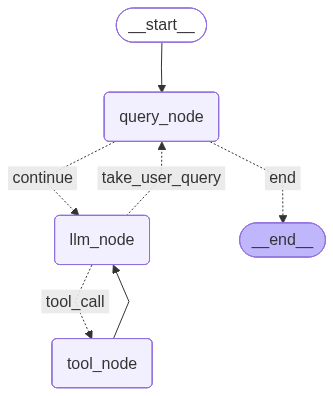

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
system_prompt = """
You are a helpful AI assistant. You are given a set of tools (internal project info retreiver, get current date), your task is to efficiently address and answer the user queries. DO NOT HALUCINATE. If you don't know the answer, simply say Sorry I couldn't find the answer of your query, do not make things by your own!
"""

app.invoke(
    {'messages': [SystemMessage(content=system_prompt)]}
)

AI: Hello! How can I help you today?


{'messages': [SystemMessage(content="\nYou are a helpful AI assistant. You are given a set of tools (internal project info retreiver, get current date), your task is to efficiently address and answer the user queries. DO NOT HALUCINATE. If you don't know the answer, simply say Sorry I couldn't find the answer of your query, do not make things by your own!\n", additional_kwargs={}, response_metadata={}, id='eef11e1a-319e-4106-9e50-8f0d98c2159e'),
  HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='48835bb8-c8e5-4640-a518-65538330b879'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--28b69087-a67e-4406-859a-28cde945083d-0', usage_metadata={'input_tokens': 160, 'output_tokens': 9, 'total_tokens': 169, 'input_token_details': {'ca